# Pulse optimization using the `krotov` package
_Will Kaufman, October 2020_



In [342]:
import qutip as qt
import krotov as kt
from krotov.parallelization import parallel_map
import numpy as np
import matplotlib.pyplot as plt

The `lambda_a` parameter defines the inverse step size used in Krotov's method (see [the docs](https://qucontrol.github.io/krotov/v1.2.0/07_krotovs_method.html#choice-of-a). Generally (based on experimentation) $\lambda_a > T^{-1}$ is a good lower bound.

In [343]:
N = 4
T = 60e-6
num_steps = 100
cs_strength = 1e2
omega_nut = 53620
lambda_a = 1e6

In [344]:
I_x = sum([
    qt.tensor(
        [qt.identity(2)]*i
        + [qt.sigmax()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_y = sum([
    qt.tensor(
        [qt.identity(2)]*i
        + [qt.sigmay()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

I_z = sum([
    qt.tensor(
        [qt.identity(2)]*i
        + [qt.sigmaz()]
        + [qt.identity(2)]*(N-i-1)
    )
    for i in range(N)
])

Define initial control amplitudes. To optimize pulses in parallel, these should be defined separately from the Hamiltonian (I think).

In [345]:
def cx(t, args):
    a0 = 0.51863079
    return a0 * kt.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T/20, func='blackman'
    )
def cy(t, args):
    return 3e-4 * kt.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T/20, func='blackman'
    )
#     return (1e-3 + -2e-3/T * t) * kt.shapes.flattop(
#         t, t_start=0, t_stop=T, t_rise=T/20, func='blackman'
#     )

In [346]:
def hamiltonian(N=4, cs_strength=1):
    """System of N spin-1/2 particles
    
    Arguments:
        N (int): Number of particles
        cs_strength (float): Strength of chemical shift interaction, in rad/s
    """
    chemical_shift = np.random.normal(scale=cs_strength, size=(N,))
    H_cs = sum([
        qt.tensor([qt.identity(2)]*i
               + [chemical_shift[i] * qt.sigmaz()]
               + [qt.identity(2)]*(N-i-1))
        for i in range(N)
    ])
    H_cx = 0.5 * omega_nut * I_x
    H_cy = 0.5 * omega_nut * I_y
    
    return [H_cs, [H_cx, cx], [H_cy, cy]]

In [347]:
H = hamiltonian(N=N, cs_strength=cs_strength)

In [348]:
tlist = np.linspace(0, T, num_steps)

In [349]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

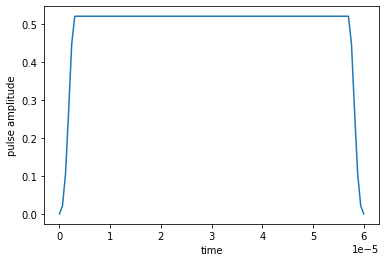

In [350]:
plot_pulse(H[1][1], tlist)

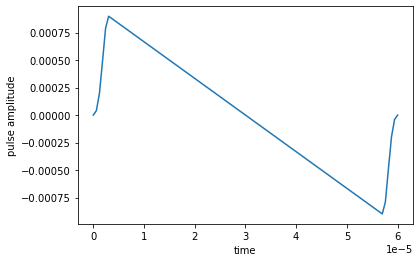

In [351]:
plot_pulse(H[2][1], tlist)

The objective specifies how states should be transformed. In this case, $|z_{+}\rangle$ should  go to $|y_{-}\rangle$ (among other state kets).

**Note**: for implementing a gate, how much should I care about characterizing each basis vector? Guess it depends on what state(s) the system could be in...

In [352]:
objectives = [
    kt.Objective(
        initial_state=qt.tensor([qt.basis(2, 0)]*N),
        target=qt.tensor([(qt.basis(2, 0) - 1j*qt.basis(2, 1)).unit()]*N),
        H=H
    )
]

In [353]:
def S(t):
    """Shape function for the field update"""
    return kt.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T/20, t_fall=T/20, func='blackman'
    )

In [354]:
pulse_options = {
    H[1][1]: dict(lambda_a=lambda_a, update_shape=S),
    H[2][1]: dict(lambda_a=lambda_a, update_shape=S),
}

In [355]:
e_ops = [
    I_x, I_y, I_z
]

e_labels = [
    r'$I_x$',
    r'$I_y$',
    r'$I_z$',
]

In [356]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=e_ops)

In [357]:
def plot_population(result, e_labels):
    fig, ax = plt.subplots()
    for i, label in enumerate(e_labels):
        ax.plot(result.times, result.expect[i], label=label)
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('expectation value')
    plt.show(fig)

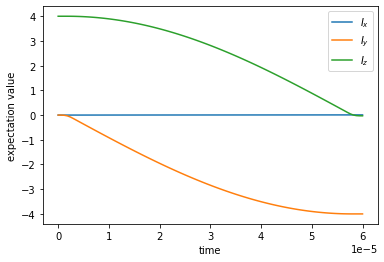

In [358]:
plot_population(guess_dynamics, e_labels)

## Single-objective optimization

In [359]:
opt_result = kt.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=kt.propagators.expm,
    chi_constructor=kt.functionals.chis_ss,
    info_hook=kt.info_hooks.print_table(J_T=kt.functionals.J_T_ss),
    check_convergence=kt.convergence.Or(
        kt.convergence.value_below('1e-3', name='J_T'),
        kt.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.00e-04    0.00e+00   1.00e-04        n/a        n/a     0
1     8.52e-05    7.36e-12   8.52e-05  -1.49e-05  -1.49e-05     0


In [360]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=e_ops)

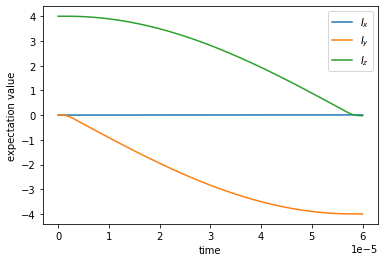

In [361]:
plot_population(opt_dynamics, e_labels)

In [362]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [363]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr0, ax_ctr1, ax_dyn] = plt.subplots(
        nrows=3, ncols=1,
        figsize=(8, 12),
        sharex=True
    )
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            kt.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=e_ops
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = [f'{label} (guess)' for label in e_labels] # '0 (guess)', '1 (guess)'
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = [f'{label} (optimized)' for label in e_labels]
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None] * len(e_labels)
        ax_ctr0.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_ctr1.plot(
            dynamics.times,
            controls[1],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        for i in range(len(e_labels)):
            ax_dyn.plot(
                dynamics.times,
                dynamics.expect[i],
                # TODO figure out below
                label=pop_labels[i],
                color=colors[i],
                ls=ls,
                alpha=alpha,
            )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('expectation')
    ax_ctr0.set_title(H_c_labels[0])
    ax_ctr0.legend()
    ax_ctr0.set_xlabel('time')
    ax_ctr0.set_ylabel('control amplitude')
    ax_ctr1.set_title(H_c_labels[1])
    ax_ctr1.legend()
    ax_ctr1.set_xlabel('time')
    ax_ctr1.set_ylabel('control amplitude')
    plt.show(fig)

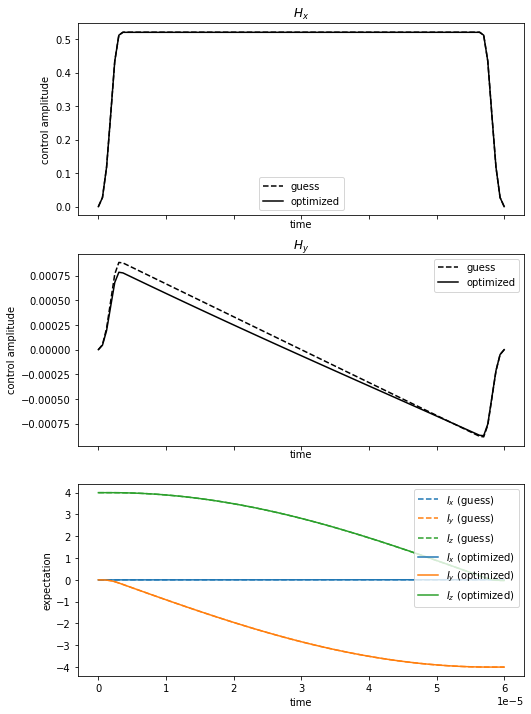

In [364]:
plot_iterations(opt_result)

## Ensemble robustness

In [365]:
def scale_control(H, *, mu):
    """Scale all control Hamiltonians by `mu`."""
    H_scaled = []
    for spec in H:
        if isinstance(spec, list):
            H_scaled.append([mu * spec[0], spec[1]])
        else:
            H_scaled.append(spec)
    return H_scaled

In [366]:
mu_vals = np.linspace(0.9, 1.1, 50)

In [367]:
def pop_error(obj, mu):
    """Population error defined as magnetization away from I_y
    """
    res = obj.mesolve(tlist, H=scale_control(obj.H, mu=mu), e_ops=[I_y])
    return N + res.expect[0][-1]

In [368]:
def _f(mu):
    return pop_error(opt_result.optimized_objectives[0], mu=mu)

pop_errors_norobust = parallel_map(_f, mu_vals)

In [369]:
def plot_robustness(mu_vals, pop_errors, pop_errors0=None):
    fig, ax = plt.subplots()
    ax.plot(mu_vals, pop_errors, label='1')
    if pop_errors0 is not None:
        ax.set_prop_cycle(None)  # reset colors
        if isinstance(pop_errors0, list):
            for (i, pop_errors_prev) in enumerate(pop_errors0):
                ax.plot(
                    mu_vals, pop_errors_prev, ls='dotted', label=("%d" % (-i))
                )
        else:
            ax.plot(mu_vals, pop_errors0, ls='dotted', label='0')
    ax.set_xlabel("Relative coupling strength")
    ax.set_ylabel('Error')
    ax.set_yscale('log')
    if pop_errors0 is not None:
        ax.legend()
    plt.show(fig)

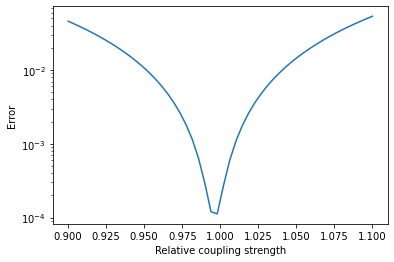

In [370]:
plot_robustness(mu_vals, pop_errors_norobust)

In [371]:
ensemble_mu = np.linspace(0.95, 1.05, 5)

In [372]:
H_ensemble = [scale_control(H, mu=mu) for mu in ensemble_mu]

In [373]:
ensemble_objectives = kt.objectives.ensemble_objectives(
    objectives, H_ensemble, keep_original_objectives=False,
)

In [374]:
def print_J_T_per_target(**kwargs):
    iteration = kwargs['iteration']
    N = len(ensemble_mu)
    num_objectives = len(objectives)
    if iteration == 0:
        print(
            "iteration "
            + "%11s " % "J_T(avg)"
            + " ".join([("J_T(μ=%.2f)" % μ) for μ in ensemble_mu])
        )
    J_T_vals = 1 - kwargs['tau_vals'].real
    J_T = np.mean(J_T_vals)
    J_T_ensemble = [np.mean(J_T_vals[i*num_objectives:(i+1)*num_objectives]) for i in range(N)]
    print(
        ("%9d " % iteration)
        + ("%11.2e " % J_T)
        + " ".join([("%11.2e" % v) for v in J_T_ensemble])
    )

In [375]:
# TODO do I need this?
pulse_options = {
    H[1][1]: dict(lambda_a=lambda_a, update_shape=S),
    H[2][1]: dict(lambda_a=lambda_a, update_shape=S),
}

In [376]:
opt_result_robust = kt.optimize_pulses(
    ensemble_objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=kt.propagators.expm,
    chi_constructor=kt.functionals.chis_re,
    info_hook=kt.info_hooks.print_table(J_T=kt.functionals.J_T_re),
    check_convergence=kt.convergence.Or(
        kt.convergence.value_below('1e-3', name='J_T'),
        kt.convergence.check_monotonic_error,
    ),
    parallel_map=(
        kt.parallelization.parallel_map,
        kt.parallelization.parallel_map,
        kt.parallelization.parallel_map_fw_prop_step,
    ),
    store_all_pulses=True,
    iter_stop=15
)

iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     1.61e-03    0.00e+00   1.61e-03        n/a        n/a     1
1     1.60e-03    3.83e-12   1.60e-03  -7.76e-06  -7.76e-06     2
2     1.60e-03    3.16e-12   1.60e-03  -6.42e-06  -6.42e-06     2
3     1.59e-03    2.63e-12   1.59e-03  -5.34e-06  -5.34e-06     2
4     1.59e-03    2.20e-12   1.59e-03  -4.46e-06  -4.46e-06     2
5     1.58e-03    1.85e-12   1.58e-03  -3.75e-06  -3.75e-06     2
6     1.58e-03    1.56e-12   1.58e-03  -3.16e-06  -3.16e-06     2
7     1.58e-03    1.32e-12   1.58e-03  -2.67e-06  -2.67e-06     2
8     1.58e-03    1.12e-12   1.58e-03  -2.26e-06  -2.26e-06     2
9     1.57e-03    9.50e-13   1.57e-03  -1.93e-06  -1.93e-06     3
10    1.57e-03    8.10e-13   1.57e-03  -1.64e-06  -1.64e-06     2
11    1.57e-03    6.92e-13   1.57e-03  -1.40e-06  -1.40e-06     2
12    1.57e-03    5.93e-13   1.57e-03  -1.20e-06  -1.20e-06     3
13    1.57e-03    5.09e-13   1.57e-03  -1.03e-06  -1.03e-06     3
14    1.57

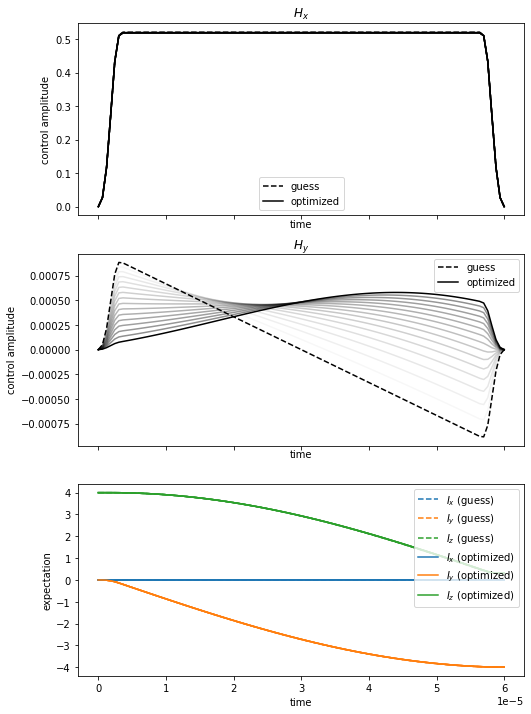

In [377]:
plot_iterations(opt_result_robust)

In [379]:
def _f(mu):
    # note: the different objectives for the ensemble have different
    # Hamiltonians, so the choice matter (i.e. must be middle one)
    return pop_error(opt_result_robust.optimized_objectives[2], mu=mu)

pop_errors_robust = parallel_map(_f, mu_vals)

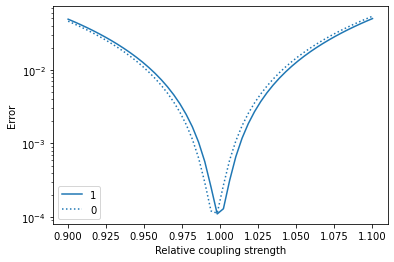

In [380]:
plot_robustness(mu_vals, pop_errors_robust, pop_errors0=[pop_errors_norobust])

For a $\pi/2$-pulse, it seems like optimizing over an ensemble doesn't improve the gate fidelity over the actual ensemble. It simply "centers" the optimal error rate at the normal coupling strength.

## Writing Bruker shape file

In [381]:
controls = opt_result_robust.optimized_controls
controls = controls[0] + 1j *  controls[1]

Define the header and footer. I'm pretty sure everything starting with `##` doesn't matter...

In [382]:
header = f"""##TITLE= 90o pulse
##JCAMP-DX= 5.00 Bruker JCAMP library
##DATA TYPE= Shape Data
##ORIGIN= Bruker BioSpin GmbH
##OWNER= <nmrsu>
##DATE= 2020/10/12
##TIME= 15:29:30
##$SHAPE_PARAMETERS= Type: Other ; Truncation Level [%] 1.0
##MINX= 0.000000E00
##MAXX= 1.000000E02
##MINY= 0.000000E00
##MAXY= 1.000000E02
##$SHAPE_EXMODE= Universal
##$SHAPE_TOTROT= 9.000000E01
##$SHAPE_TYPE= Excitation
##$SHAPE_USER_DEF=
##$SHAPE_REPHFAC=
##$SHAPE_BWFAC= 0.000000E00
##$SHAPE_BWFAC50=
##$SHAPE_INTEGFAC= 0.000000E00
##$SHAPE_MODE= 0
##NPOINTS= {len(controls)}
##XYPOINTS= (XY..XY)
"""

footer = """##END=
"""

The amplitudes must be in percent (0-100) and the phases must be in degrees (0-360).

In [383]:
string = header
for i in controls:
    string += (f'{np.abs(i)*100 :.06e}, '
               + f'{np.mod(np.angle(i, deg=True), 360) :.06e}\n')
string += footer

In [385]:
with open('WJK_Shaped_X.txt', 'w') as f:
    f.write(string)